<a href="https://colab.research.google.com/github/qiangy0819/plugin-GUI/blob/master/Assignment_4_Fall2022_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENGS 108 Fall 2022 Assignment 4**

*Due October 11, 2022 at 11:59PM on Github*

**Instructors:** George Cybenko

**TAs:** Chase Yakaboski and Clement Nyanhongo


---

## **Rules and Requirements**


1.   You are only allowed to use Python packages that are explicity imported in 
the assignment notebook or are standard (bultin) python libraries like random, os, sys, etc, (Standard Bultin Python libraries will have a Python.org documentation). For this assignment you may use:
  *   [numpy](https://numpy.org/doc/stable/)
  *   [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
  *   [scikit-learn](https://scikit-learn.org/stable/)
  *   [matplotlib](https://matplotlib.org/)
  *   [tensorflow](https://www.tensorflow.org/)

2.   All code must be fit into the designated code or text blocks in the assignment notebook. They are indentified by a **TODO** qualifier.

3. For analytical questions that don't require code, type your answer cleanly in Markdown. For help, see the [Google Colab Markdown Guide](https://colab.research.google.com/notebooks/markdown_guide.ipynb).

---


In [11]:
''' Import Statements '''
import os
import csv
import json
import pickle
import tqdm
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Data Loading
In this assignment we will be using the Yoga Postures Dataset from [Kaggle](https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset) and will use the following code blocks to download the dataset directly to your Google Drive.

## Creating a Kaggle API Token
First we will need to download an API token from Kaggle in order to download the dataset, so our first step is to create a Kaggle account if you don't already have one.
1. Create a Kaggle account by following the sign up instructions [here](https://www.kaggle.com/).
2. Log into your Kaggle account and click your account icon on the upper righthand side. 
3. Then select **Account** from the dropdown/sidebar menu.
4. Scroll down to the **API** section and select **Create New API Token**.
5. This will download a JSON file called kaggle.json to your Downloads folder on your computer.
6. Now run the following code block and when the **Browse** button appears, click it and select that kaggle.json file. 

In [12]:
# Run this code block after creating a Kaggle API token as instructed above.
! pip install -q kaggle
from google.colab import files 

# Will ask you to upload kaggle.json file and remove any old ones.
if os.path.exists('kaggle.json'):
  os.remove('kaggle.json')
files.upload()

# Will create the appropriate directory structure
if not os.path.exists('/root/.kaggle'):
  ! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Downloading the Dataset

7. Now we have downloaded our Kaggle credentials we can now download the Yoga Postures Dataset (or any other Kaggle dataset for that matter) directly into our Google Drive.

In [13]:
# Will ensure a train directory exists in your home and will create if it doesn't exist.
if not os.path.exists('train'):
  os.mkdir('train')
# Will download the yoga postures dataset zip file if it does not exist in the train directory.
if not os.path.exists('train/yoga-posture-dataset.zip'):
  ! kaggle datasets download -p train tr1gg3rtrash/yoga-posture-dataset
# Will check to see if the yoga postures zip file has been unzipped and will unzip the file if not.
if not os.path.exists('train/Poses.json'):
  ! unzip train/yoga-posture-dataset.zip -d train

# To remove train folder and redownload uncomment the code below
# !rm -rf train

 99% 443M/447M [00:04<00:00, 129MB/s]
100% 447M/447M [00:04<00:00, 113MB/s]
Archive:  train/yoga-posture-dataset.zip
  inflating: train/Adho Mukha Svanasana/File1.png  
  inflating: train/Adho Mukha Svanasana/File10.png  
  inflating: train/Adho Mukha Svanasana/File11.png  
  inflating: train/Adho Mukha Svanasana/File12.png  
  inflating: train/Adho Mukha Svanasana/File13.png  
  inflating: train/Adho Mukha Svanasana/File14.png  
  inflating: train/Adho Mukha Svanasana/File15.png  
  inflating: train/Adho Mukha Svanasana/File16.png  
  inflating: train/Adho Mukha Svanasana/File17.png  
  inflating: train/Adho Mukha Svanasana/File18.png  
  inflating: train/Adho Mukha Svanasana/File19.png  
  inflating: train/Adho Mukha Svanasana/File2.png  
  inflating: train/Adho Mukha Svanasana/File20.png  
  inflating: train/Adho Mukha Svanasana/File21.png  
  inflating: train/Adho Mukha Svanasana/File22.png  
  inflating: train/Adho Mukha Svanasana/File23.png  
  inflating: train/Adho Mukha Svanasa

## Viewing the Dataset Metadata
Now let's inspect the dataset metadata, i.e. the information about each of the training examples, which is located in the Poses.json file.

In [14]:
# Let's load the yoga postures metadata
import json
with open('train/Poses.json', 'r') as metafile:
  metadata = json.load(metafile)
metadata = pd.DataFrame.from_dict(metadata['Poses'])
metadata.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


## Pre-Problem: Segmenting Out the Test Data and Copying to Google Drive
A part of this homework will be a competition. Included in your assignment github repo, there is a file called **test_images.csv**. This file holds all of the image paths that you are **NOT** allowed to use during *training*. Therefore, what we are going to do in this pre-problem is remove all the testing images from your train data folder. *Hint:* You naturally are still allowed/should use the test data to evaluate your model moving foward, you're just not allowed to use these images during training.

### Task 1
Using the code available in the Data loading section as a reference, write a command using the "!" colab operator to create a new directory called **test**.

In [15]:
#TODO: Write one line of code to make a new directory called test (You might need to refresh your files view to see the change)
! mkdir test

### Task 2
Upload your **test_images.csv** file by running the following code block.

In [16]:
files.upload()

Saving test_images.csv to test_images.csv


{'test_images.csv': b'Virabhadrasana Two/File41.png\r\nVirabhadrasana Two/File15.png\r\nVirabhadrasana Two/File49.png\r\nVirabhadrasana Two/File36.png\r\nVirabhadrasana Two/File29.png\r\nVirabhadrasana Two/File34.png\r\nVirabhadrasana Two/File14.png\r\nVirabhadrasana Two/File61.jpeg\r\nVirabhadrasana Two/File25.png\r\nVirabhadrasana Two/File28.png\r\nVirabhadrasana Two/File44.png\r\nVirabhadrasana Two/File13.png\r\nUpavistha Konasana/File8.jpeg\r\nUpavistha Konasana/File3.jpeg\r\nUpavistha Konasana/File6.jpeg\r\nSetu Bandha Sarvangasana/File65.jpeg\r\nSetu Bandha Sarvangasana/File60.jpg\r\nSetu Bandha Sarvangasana/File41.png\r\nSetu Bandha Sarvangasana/File50.jpg\r\nSetu Bandha Sarvangasana/File6.png\r\nSetu Bandha Sarvangasana/File23.png\r\nSetu Bandha Sarvangasana/File13.png\r\nSetu Bandha Sarvangasana/File48.jpg\r\nSetu Bandha Sarvangasana/File12.png\r\nSetu Bandha Sarvangasana/File15.png\r\nSetu Bandha Sarvangasana/File68.jpeg\r\nSetu Bandha Sarvangasana/File17.png\r\nSetu Bandha S

### Task 3
Now let's write some code to copy over all these test images into the test folder we created as well as removing them from the train folder.

In [17]:
# First let's load the test_images.csv file
with open('test_images.csv', 'r') as f_:
  reader = csv.reader(f_)
  test_image_paths = []
  for row in reader:
    test_image_paths.append(row[0])

In [18]:
# TODO: Now using these test image paths, copy over these files to the test directory and remove them from the train directory
for test_path in test_image_paths:
  train_path = os.path.join("train",test_path)
  dest_dir = os.path.join('test',os.path.dirname(test_path))
  if not os.path.exists(dest_dir):
    ! mkdir -p "$dest_dir"
  ! mv "$train_path" "$dest_dir"
  # Do something... (hint see cp and rm commands using the colab terminal, i.e. the "!" operator)

### Task 4
Now that we have our test and training sets setup, let's copy them over to our Google Drive so that we don't have to run this pipeline again.

1. Mount your Google Drive in colab in the standard way by running the following code block.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Now run the following command to copy over the training and test data to your desired location. Remember this location so you don't have to run this data loading section everytime you want to work on your homework.

In [20]:
# DESIRED GOOGLE DRIVE DIRECTORY (CHANGE ME)
DESIRED_GOOGLE_DRIVE_DIR = '/content/drive/MyDrive/data/yoga-poses'

# Makes the desired directory. If you get an error then the directory likely already exists, so comment out this line.
! mkdir -p $DESIRED_GOOGLE_DRIVE_DIR

# Command to copy over all test and train data to desired google drive path
! cp -r train $DESIRED_GOOGLE_DRIVE_DIR
! cp -r test $DESIRED_GOOGLE_DRIVE_DIR

# Problem 1: Support Vector Machine Classification
In this problem, you will be building support vector machines for some cool classification tasks.

## Task 1: Synthetic Data
 In this part we will be exploring the *circles* dataset. This dataset is avialable as a pickle file labeled *circles.pk* in your assignment repository under datasets. In this dataset you will have an $X$ array of 2 dimensional samples of the form $(x_1, x_2)$ and a $y$ array of each samples associated label. 

### Part A
Upload this dataset to your Google Drive and load the dataset into memory using the pickle module (*Hint: Refer to previous assignments to figure out how to do this*). Go through the circles dataset and create a scatterplot of the circles data using the y label as each sample's color to designate their respective class.

In [34]:
# TODO: Change me
import pickle
CIRCLES_DATASET_PATH = '/content/drive/MyDrive/data/circles/circles.pk'
files.upload()
UPLOAD_PATH = '/content/circles.pk'
DESIRED_PATH = '/content/drive/MyDrive/data/circles'
! mkdir -p $DESIRED_PATH
! mv "$UPLOAD_PATH" "$DESIRED_PATH" 
# TODO: Load the dataset using pickle load 
with open(CIRCLES_DATASET_PATH, 'rb') as circles_file:
  # TODO: Load here...
  circles = pickle.load(circles_file)

Saving circles.pk to circles (2).pk


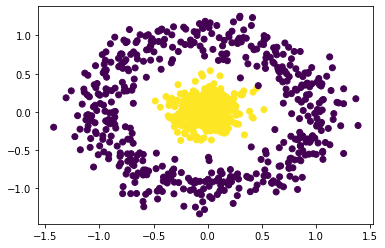

In [52]:
X, y = circles
plt.scatter(X[:,0],X[:,1],c = y)
# TODO: Graph the data

### Part B
Is this dataset linearly seperable? Explain why or why not?

$No. The~data~ is~ ring-shaped~, a~ line~ can~ never~ separate~ the~ data~ well.$

### Part C
Can you think of a transformation that can be applied to this dataset that could make it linearly seperable? If so, define what these transformation function(s) might look like, and if not explain why. *Hint: Think of a higher dimensional space.*

**TODO:** Your answer should go here.

### Part D
If you where able to find a transformation in (Part C), create a suitable graph showing that the dataset is linearly seperable in this new feature space.

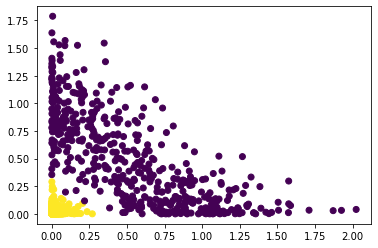

In [54]:
#TODO: Your code goes here.
plt.scatter(X[:,0]**2,X[:,1]**2,c = y)



## Task 2: Yoga Pose Classification
What we accomplished in Part 1 is known as the kernel trick for SVMs. Now let's focus on how we can use this idea to accomplish non-linear classification on a real world dataset. In this next part and throughout the remainder of the assignment we will be using a yoga postures dataset. These images are PNG and JPEG images with many pixels. 

### Part A
You have been given a number of code skeletons throughout the course all of which load and preprocess the data for you. In this excerise tho, we will be doing the data loading manually as it is an important skill to learn. Write some code that will walk through the *Yoga Postures Dataset* directory structure and build a single large numpy array (Make sure to resize the image to something like (28, 28) or (32, 32) for the SVM and at minimum (71, 71) for the deep learning tasks) *Hint: You have been provided with a basic skeleton, study the operations of the code and finish the script.*

In [ ]:
from PIL import Image

# TODO: Change Me
PATH_TO_YOGA_TRAIN_DATA = '/content/drive/MyDrive/data/yoga-poses/train'
PATH_TO_YOGA_TEST_DATA = '/content/drive/MyDrive/data/yoga-poses/test'

# The dimensions of the resized image
RESIZE = (71,71)
# A map from integer ids to yoga pose categories (strings)
pose_map = {}
# The data lists that we will be filling in.
X, y = [], []

# Let's start our for loop (Just using tqdm to give us a pretty progress bar).
class_id = 0
for subfold in tqdm.tqdm(os.listdir(PATH_TO_YOGA_TRAIN_DATA), desc='Processing training images', leave=False):                                                                             
  if os.path.isdir(os.path.join(PATH_TO_YOGA_TRAIN_DATA, subfold)):
    # We have found image class folder so let's extract all example data
    pose_map[class_id] = subfold
    for img_name in os.listdir(os.path.join(PATH_TO_YOGA_TRAIN_DATA, subfold)):
      #TODO: Preprocess and load image
      #HINT: PNGs will have 4 channels and JPEGs will have 3 (THIS WILL CAUSE ISSUES!).
      # Try to figure out what to do with this 4th channel. It could be as simple as deleting it...
    class_id += 1

X_train = np.array(X)
y_train = np.array(y)

# Let's load in the training data as well using the same methodology but with the pose_map built during the training data collection. 
pose_map_reverse = {pose: class_id for class_id, pose in pose_map.items()}
X, y = [], []
for subfold in tqdm.tqdm(os.listdir(PATH_TO_YOGA_TEST_DATA), desc='Processing test images', leave=False):                                                                             
  if os.path.isdir(os.path.join(PATH_TO_YOGA_TEST_DATA, subfold)):
    # We have found image class folder so let's extract all example data
    class_id = pose_map_reverse[subfold]
    for img_name in os.listdir(os.path.join(PATH_TO_YOGA_TEST_DATA, subfold)):
      #TODO: Preprocess and load image

X_test = np.array(X)
y_test = np.array(y)

### Part B
Implement a SVM classifer using sklearn and report your classification results on the testing dataset. Make sure to flatten your X data from the three channels before passing into the SVM.

In [ ]:
#TODO: Build and fit your SVM classifier and print your classification report

# Problem 2: Introduction to TensorFlow
In this problem, we will start working in tensorflow to build deep learning systems starting with fully-connected (FC) and convolutional (CNN) neural networks. We will focus on using the yoga postures dataset, ending this problem with a small class competition that may come with a prize...

## Task 1: A Fully-Connected Neural Network

### Part A
Using the yoga postures dataset, build a [tensorflow Data Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) that is shuffled with a batch size of 10. *Hint: We did this in class.*

In [ ]:
#TODO: Your code goes here.

### Part B
Build a two layer fully connected neural network of any size with a ReLu activation function and a final softmax layer.

In [ ]:
#TODO: Your code goes here. Make sure to add a Flatten layer first with the correct input shape.

### Part C
Compile your model with an appropriate loss function and optimizer. Briefly describe your choices.

In [ ]:
#TODO: Your code goes here.

### Part D
Train your model on the yoga pose training dataset. And report your accuracy on the testing dataset.

In [ ]:
#TODO: Your code goes here. Hint: It's ok if the accuracy is not the best...

## Task 2: A Convolutional Neural Network
CNNs perform notoriously well on image classification tasks, so we will study a simple implementation of this network and let you guys compete to see who finds the best architecture. 

### Part A: Vanilla CNN
Build, compile, and fit a CNN with the following network structure:
* A total of 3 convolutional segments consisting of:
  - A convolutional layer with "valid" padding and Relu activation and your choice of kernel size, number of filters and strides,
  - An average pooling layer,
* Then a fully connected layer with 128 neurons with ReLu activations.
* Then a fully connected layer with 64 neurons and ReLu activations.
* And ending with a softmax output layer.



In [ ]:
#TODO: Build, compile and train this network on the yoga pose training data. Maybe this one will be better...

### Part B: Transfer Learning
Now we are going to steal from a state-of-the-art [Xception](https://arxiv.org/abs/1610.02357) model. Luckily, tensorflow has this directly available to us and we are going to use transfer learning to tune this SoA model to our dataset. Therefore, run the following code block to build our base Xception model:

In [ ]:
# I'll setup your base model for you.
from tensorflow.keras.applications import Xception

base_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(71,71,3)
)
base_model.trainable=False

Now create a new model with this *base_model* as our first layer followed by:
* Global average pooling layer,
* A Dense layer with 256 neurons and ReLu activations,
* A 40% Dropout layer,
* A softmax output layer.

Then fit this model on 30 epochs.

In [ ]:
#TODO: Finish the model
model = tf.keras.Sequential([
    base_model,
    #TODO: Add other layers
])

#TODO: Compile model

In [ ]:
#TODO: Fit the model on 30 epochs

### Part C: Build your Own Model
So know that you know the range of accuracies between poorly built models and state-of-the-art models like Xception, can you improve on them? Attempt to build your own deep neural network architecture and see if you can do better than the base CNN model presented above or better yet the Xception model we transfer learned. You may use any architecture or configuration you like.

In [ ]:
#TODO: Build and train your custom model and evaluate on the test data.

### Part D: Compete!
To enter the class competition for the best model save out your model as a H5 file and upload it to your assignment repo using the following code block.

In [ ]:
#TODO: Save your tensorflow model with:
model.save('/content/drive/MyDrive/models/yoga-cnn.h5')
#TODO: Download your model from Google Drive and upload that saved file to your github assignment repo when you submit your assignment.